In [21]:
import pandas as pd
import json
import csv
import os
import numpy as np
import torch
import openai
import re
from collections import defaultdict

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tqdm

### Dataset analysis

In [ ]:
entities_path = "../data/entities_gt.csv"
entities = pd.read_csv(entities_path)

In [4]:
data_path="../data/final_NER_labeled_dataset.csv"
with open(data_path, 'r') as f:
    ner_tables = json.load(f)  

In [5]:
len(ner_tables)

51271

### Check if any tables with only O annotation

In [6]:
len(ner_tables)

51271

In [7]:
empty_tables = []
empty_bio = []
tab_ids = []
num_unique = []
s = 0
j = 0
for idx in range(len(ner_tables)):
    
    ser_correct_annot = []   
    tab_annotation = []
    bio_annotation = []
    
    table = ner_tables[idx][0]
    tab_id = table[0]
    tableHeaders = table[4]
    table_data = table[5]

    row_labels = table[6]
    
    #if tab_id == "102213-2":
    #    print(idx)
    for row in row_labels:       
        for span in row:            
            if len(span)>0:
               # print(span)
                for i in range(len(span)):
                    cls = span[i][-1]
                    if type(cls) == int:
                        tab_annotation.append(cls)
                    else:
                        bio_annotation.append(cls)
                        
    unique_span = set(tab_annotation)
    num_unique.append(len(unique_span))
   
    if all(x==0 for x in tab_annotation):
        s += 1
        empty_tables.append(idx)      
    if all(y=='O' for y in bio_annotation):
        j += 1
        empty_bio.append(idx)
        tab_ids.append(tab_id)

In [25]:
len(empty_tables)

0

In [5]:
ner_tables[160]

[['10222554-1',
  'Florida State Road 111',
  'Major junctions',
  'Major junctions',
  [[[-1, 0], 'Mile'], [[-1, 1], 'Destinations'], [[-1, 2], 'Notes']],
  [[[0, 0], '0.0'],
   [[0, 1],
    'Category:Jct template transclusions with missing shields SR 21 (Blanding Boulevard)'],
   [[0, 2], 'Southern terminus'],
   [[1, 0], '0.4'],
   [[1, 1],
    'Category:Jct template transclusions with missing shields SR 128 (San Juan Avenue)'],
   [[1, 2], ''],
   [[2, 0], '2.3'],
   [[2, 1],
    'Category:Jct template transclusions with missing shields SR 228 (Normandy Boulevard/Post Street)'],
   [[2, 2], ''],
   [[3, 0], '2.8'],
   [[3, 1],
    'Category:Jct template transclusions with missing shields Category:Jct template transclusions with missing shields I-10 / SR 8'],
   [[3, 2], 'Exit 358 (I-10)'],
   [[4, 0], '3.6'],
   [[4, 1],
    'Category:Jct template transclusions with missing shields Category:Jct template transclusions with missing shields US 90 / SR 10 (West Beaver Street)'],
   [[4

In [14]:
len(empty_bio)

22

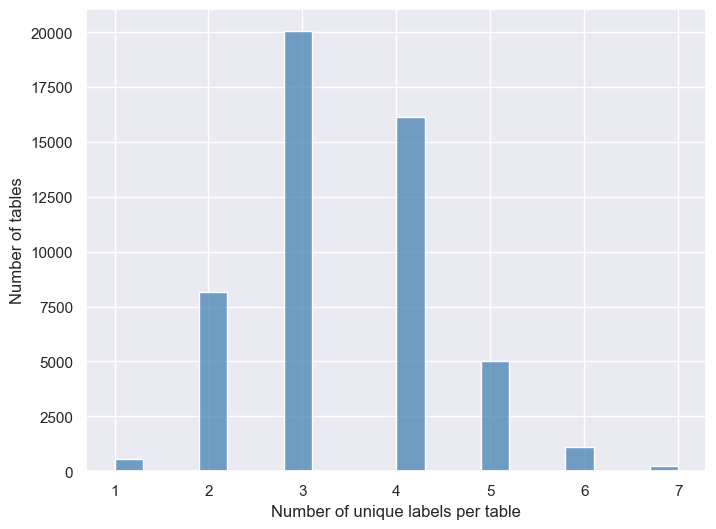

In [26]:
sns.set(rc={'figure.figsize':(8,6)})

fig, ax = plt.subplots(1)

sns.histplot(num_unique,kde=False,ax=ax,stat="count",binrange=[1,7], bins=20, color='steelblue')
ax.set(xlabel='Number of unique labels per table', ylabel='Number of tables')
plt.savefig("plots/num_unique_labels_per_table.png")
plt.show()

In [9]:
for idx in empty_bio:
    del ner_tables[idx][0]

In [10]:
filtered_tables = [sublist for sublist in ner_tables if len(sublist) > 0]

In [12]:
len(filtered_tables) # after removing 22 tables which had only 'O' annotation

51271

In [13]:
with open('../data/final_NER_labeled_dataset.csv', 'w') as f:
    json.dump(filtered_tables, f)

In [19]:
with open('../data/final_NER_labeled_dataset_filtered.json', 'w') as f:
    json.dump(data, f)

### Analysis of dataset

In [7]:
data = ner_tables

In [ ]:
num_cells = []
num_tokens = []
num_unprocessed_rows=[]
num_rows_after_clipping = []
num_diff_labels = []

with tqdm(total=len(dataset)) as progress:
    for i in range(len(dataset)):
        table = dataset.iloc[i]
        table_data = table["tableData"]
        data_rows = [ r for r in table_data ] 
        num_unprocessed_rows.append(len(data_rows))

        cells = [ [cell["tokens_ids"]+[102] for cell in row] for row in data_rows ] # add special classes [CLS] and [SEP]
        num_cells.append(len([c for row in data_rows for c in row]))

        input_ids = torch.cat((torch.tensor([101]),torch.tensor([t for row in cells for cell in row for t in cell])))
        num_tokens.append(input_ids.shape[0])

        input_ids_row = [[t for cell in row for t in cell] for row in cells]
        num_rows=0
        x=0
        rem=511
        while x < len(input_ids_row)-1:
            if len(input_ids_row[x])<rem:
                num_rows+=1
                x+=1
                rem = rem - len(input_ids_row[x])
            else:
                break
        

        labels= [ [cell["mapped"]+[["[SEP]","-100"]] for cell in row] for row in data_rows ]
        linearized_labels= [t[1] for row in labels for cell in row for t in cell]
        if len(linearized_labels)<511:
            linearized_labels=linearized_labels[:512]

        num_diff_labels.append(len(set([i for i in linearized_labels if i != "-100"])))


        num_rows_after_clipping.append(num_rows)
        progress.update()

In [14]:
n_rows=[]
n_columns=[]
n_entities_cell=[]

for i in range(len(data)):
    table=data[i]
    cells = table[0][5]
    entities =table[0][6] 
    
    n_row = cells[-1][0][0]
    n_col = cells[-1][0][1]    

    n_rows.append(n_row)
    n_columns.append(n_col)
    
    n_entities_cell.append(entities)

In [13]:
mean_rows = np.mean(n_rows)
mean_columns =np.mean(n_columns)
print(mean_rows)
print(mean_columns)

7.231300345224396
4.087183788106337


In [165]:
# Previously total num of labeled entities : 1 081455, + 810252 as O

In [166]:
#labels_dict = {"Organization":0,
#"ArchitecturalStructure":1,
#"Event":2,
#"Place":3,
#"Person":4,
#"Work":5}
#labels_dict={v:k for k,v in labels_dict.items()}
#print(labels_dict)

In [17]:
types_dict={}
for i in range(8):
    types_dict[i]=0

for table in n_entities_cell:
    if table != []:
        for cell in table:
            es=cell[0]            
            for e in es:                
                if e !=[]:
                    types_dict[e[-1]]+=1
print(types_dict)

{0: 504236, 1: 15094, 2: 220739, 3: 66581, 4: 74948, 5: 386955, 6: 571686, 7: 55813}


In [16]:
# Currently total num of labeled entities: 1 391810, + 504242 as O

In [18]:
del types_dict[0]

In [19]:
labels_dict = {  'Activity': 1,
                 'Organisation': 2,
                 'ArchitecturalStructure': 3,
                 'Event': 4,
                 'Place': 5,
                 'Person': 6,
                 'Work': 7,
                }
labels_dict={v:k for k,v in labels_dict.items()}
print(labels_dict)

{1: 'Activity', 2: 'Organisation', 3: 'ArchitecturalStructure', 4: 'Event', 5: 'Place', 6: 'Person', 7: 'Work'}


In [20]:
labels = [label for label in labels_dict.keys()]
values = [value for value in types_dict.values()]

/var/folders/zs/qtbkgfnj1bd_qhkkmfc294j80000gn/T/ipykernel_57054/401211315.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=data, palette='Pastel1')


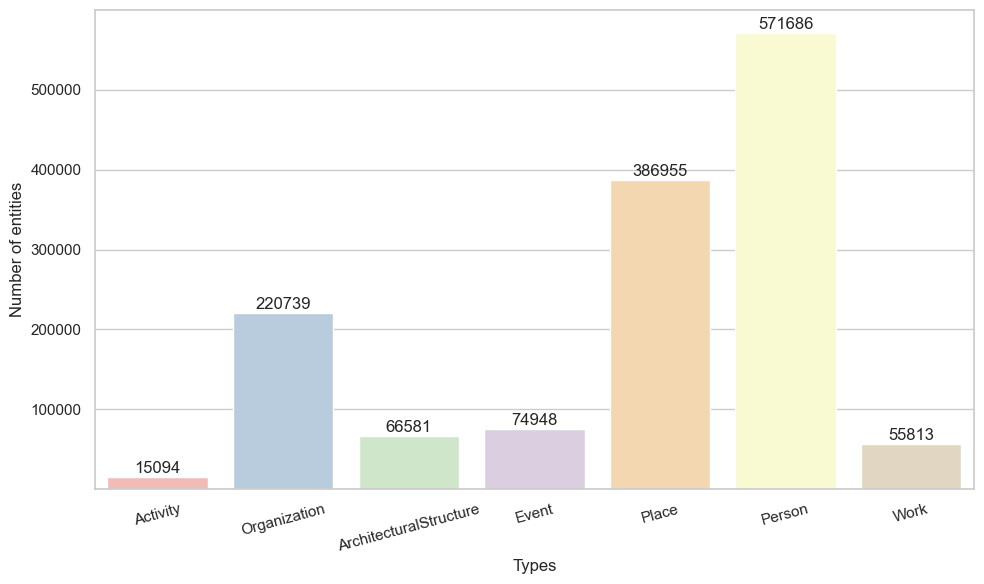

In [21]:
data = [value for value in types_dict.values()]
labels = ['Activity', 'Organization', 'ArchitecturalStructure', 'Event', 'Place', 'Person', 'Work']

# Create a barplot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=labels, y=data, palette='Pastel1')

ax.set_xlabel('Types')
ax.set_ylabel('Number of entities')

for i, v in enumerate(data):
    ax.text(i, v + 1000, str(v), ha='center', va='bottom')
    
plt.yticks([100000, 200000,300000,400000,500000])
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("plots/num_entities_per_type_final.png")
plt.show()

In [36]:
len(n_entities_cell) #num tables

51271

In [147]:
avg_entities_per_cell=[]
sum_entities_per_table=[]

for table in n_entities_cell:
    per_table = 0
    entities_per_cell = []
    
    for cell in table:
        per_cell = 0
        entities = cell[0]
        for e in entities:
            if e[-1] != 0:
                per_cell+=1

        entities_per_cell.append(per_cell)
        per_table += per_cell

    avg_entities_per_cell.append(np.mean(entities_per_cell))
    sum_entities_per_table.append(per_table)

In [148]:
len(sum_entities_per_table) # number of annotated entities per table

2000

In [149]:
max(sum_entities_per_table)

196

[Text(0.5, 0, 'Number of labeled entities per table'),
 Text(0, 0.5, 'Number of tables')]

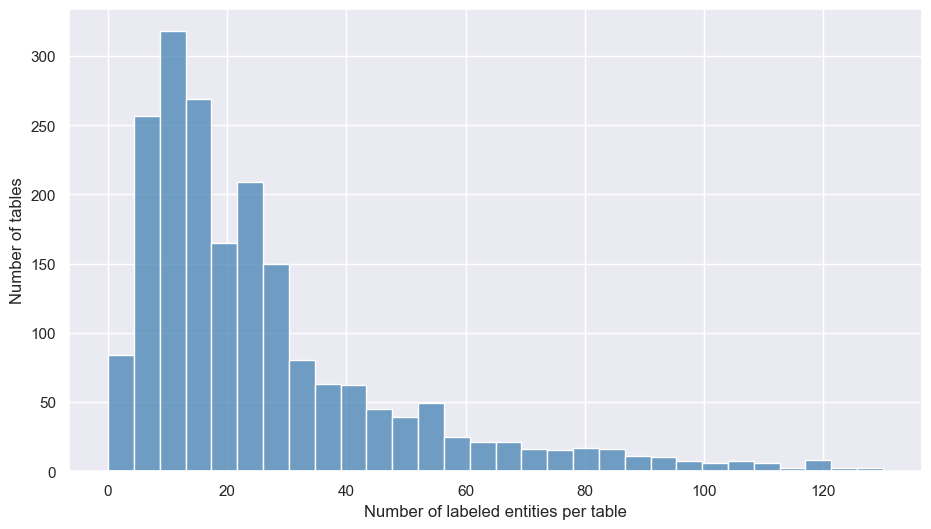

In [151]:
sns.set(rc={'figure.figsize':(11,6)})

fig, ax = plt.subplots(1)

sns.histplot(sum_entities_per_table,kde=False,ax=ax,stat="count",binrange=[0,130], bins=30, color='steelblue')
ax.set(xlabel='Number of labeled entities per table', ylabel='Number of tables')
#fig.savefig("plots/ser_entities_per_table.png")

[Text(0.5, 0, 'Number of labeled entities per cell - average per table'),
 Text(0, 0.5, 'Number of tables')]

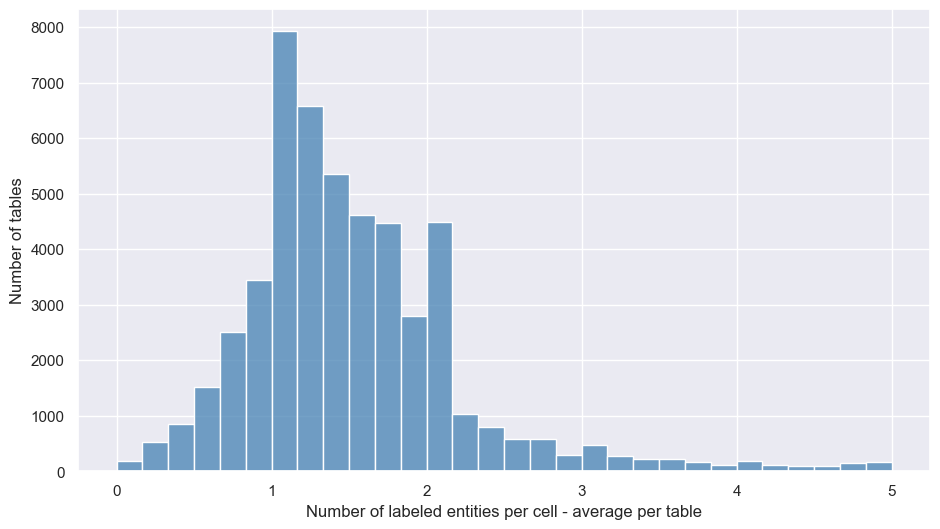

In [61]:
sns.set(rc={'figure.figsize':(11,6)})

fig, ax = plt.subplots(1)

sns.histplot(avg_entities_per_cell,kde=False,ax=ax,stat="count",binrange=[0,5],bins=30, color='steelblue')
ax.set(xlabel='Number of labeled entities per cell - average per table', ylabel='Number of tables')

## Test set analysis

In [5]:
seed_nr = 42
generator = torch.Generator().manual_seed(seed_nr)

In [6]:
train_set, test_set = torch.utils.data.random_split(ner_tables, [49271, 2000], generator=generator)

In [7]:
len(test_set)

2000

In [138]:
n_rows=[]
n_columns=[]
n_entities_cell=[]

for i in test_set.indices:
    table=data.iloc[i]
    cells = table[0][5]
    entities =table[0][6] 
       
    
    n_row = cells[-1][0][0]
    n_col = cells[-1][0][1]    

    n_rows.append(n_row)
    n_columns.append(n_col)
    
    n_entities_cell.append(entities)

In [139]:
mean_rows = np.mean(n_rows)
mean_columns =np.mean(n_columns)
print(mean_rows)
print(mean_columns)

7.1905
4.0615


In [150]:
types_dict={}
for i in range(8):
    types_dict[i]=0

for table in n_entities_cell:
    if table != []:
        for cell in table:
            es=cell[0]            
            for e in es:                
                if e !=[]:
                    types_dict[e[-1]]+=1
print(types_dict)

{0: 20141, 1: 704, 2: 8706, 3: 2299, 4: 2679, 5: 15007, 6: 22149, 7: 2285}


## Plot results

### Line plots per model, per class

In [8]:
 labels_dict = { 'Activity': '1',
                 'Organisation': '2',
                 'ArchitecturalStructure': '3',
                 'Event': '4',
                 'Place': '5',
                 'Person': '6',
                 'Work': '7',
                }
labels_dict={v:k for k,v in labels_dict.items()}
print(labels_dict)

{'1': 'Activity', '2': 'Organisation', '3': 'ArchitecturalStructure', '4': 'Event', '5': 'Place', '6': 'Person', '7': 'Work'}


In [5]:
model_1 = pd.read_csv(os.path.join('../output', 'results_gpt-35-turbo-instruct_0_bar_True'+'.csv'))
model_1 = model_1.rename(columns=labels_dict)  

model_1 = model_1[model_1['num_tab']<=550]

In [8]:
model_2 = pd.read_csv(os.path.join('../output', 'results_gpt-35-turbo_0_bar_random'+'.csv'))
model_2 = model_2.rename(columns=labels_dict)  

model_2 = model_2[model_2['num_tab']<=550]

In [10]:
model_3 = pd.read_csv(os.path.join('../output', 'results_gpt-4_0_bar_random'+'.csv'))
model_3 = model_3.rename(columns=labels_dict)  

model_3 = model_3[model_3['num_tab']<=550]

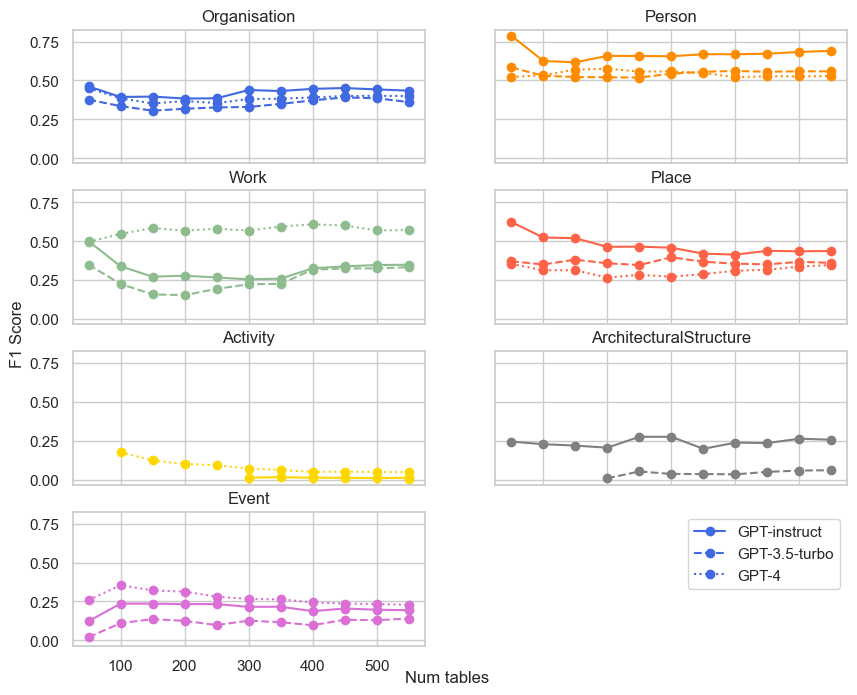

In [57]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(4, 2, figsize=(10, 8), sharex=True, sharey=True)
axs[0, 0].plot(model_1['num_tab'], model_1['Organisation'], label='Organisation', linestyle='-', marker='o',color = 'royalblue')
axs[0, 0].plot(model_2['num_tab'], model_2['Organisation'], linestyle='--', marker='o',color = 'royalblue')
axs[0, 0].plot(model_3['num_tab'], model_3['Organisation'], linestyle=':', marker='o',color = 'royalblue')
axs[0, 0].set_title('Organisation')

axs[0, 1].plot(model_1['num_tab'], model_1['Person'], label='Person', linestyle='-', marker='o',color = 'darkorange')
axs[0, 1].plot(model_2['num_tab'], model_2['Person'], linestyle='--', marker='o',color = 'darkorange')
axs[0, 1].plot(model_3['num_tab'], model_3['Person'], linestyle=':', marker='o',color = 'darkorange')
axs[0, 1].set_title('Person')

axs[1, 0].plot(model_1['num_tab'], model_1['Work'], label='Work', linestyle='-', marker='o',color = 'darkseagreen')
axs[1, 0].plot(model_2['num_tab'], model_2['Work'], linestyle='--', marker='o',color = 'darkseagreen')
axs[1, 0].plot(model_3['num_tab'], model_3['Work'], linestyle=':', marker='o',color = 'darkseagreen')
axs[1, 0].set_title('Work')


axs[1, 1].plot(model_1['num_tab'], model_1['Place'], label='Place', linestyle='-', marker='o',color = 'tomato')
axs[1, 1].plot(model_2['num_tab'], model_2['Place'], linestyle='--', marker='o',color = 'tomato')
axs[1, 1].plot(model_3['num_tab'], model_3['Place'], linestyle=':', marker='o',color = 'tomato')
axs[1, 1].set_title('Place')


axs[2, 0].plot(model_1['num_tab'], model_1['Activity'], label='Activity', linestyle='-', marker='o',color = 'gold')
axs[2, 0].plot(model_2['num_tab'], model_2['Activity'], linestyle='--', marker='o',color = 'gold')
axs[2, 0].plot(model_3['num_tab'], model_3['Activity'], linestyle=':', marker='o',color = 'gold')
axs[2, 0].set_title('Activity')

axs[2, 1].plot(model_1['num_tab'], model_1['ArchitecturalStructure'], label='Architectural Structure', linestyle='-', marker='o',color = 'grey')
axs[2, 1].plot(model_2['num_tab'], model_2['ArchitecturalStructure'], linestyle='--', marker='o',color = 'grey')
axs[2, 1].set_title('ArchitecturalStructure')

axs[3, 0].plot(model_1['num_tab'], model_1['Event'], label='Event', linestyle='-', marker='o',color = 'orchid')
axs[3, 0].plot(model_2['num_tab'], model_2['Event'], linestyle='--', marker='o',color = 'orchid')
axs[3, 0].plot(model_3['num_tab'], model_3['Event'], linestyle=':', marker='o',color = 'orchid')
axs[3, 0].set_title('Event')

fig.text(0.5, 0.07, 'Num tables', ha='center', va='center')
fig.text(0.07, 0.5, 'F1 Score', ha='center', va='center', rotation='vertical')

fig.delaxes(axs[3,1])

fig.legend(['GPT-instruct', 'GPT-3.5-turbo', 'GPT-4'], bbox_to_anchor=axs[-1,-1].get_position(), bbox_transform=fig.transFigure)

plt.savefig("../output/plots/"+ "All_class_all_mod_0shot.png")

## F1, P and Recall per model

In [183]:
def plot_results(model_name, shot, labels_dict):
    
    file_name = 'results_{}_{}'.format(model_name, shot)   
    data = pd.read_csv(os.path.join('../output/comma_deli', file_name+'.csv'))
    data = data.rename(columns=labels_dict)  
    
   # data = data[data['num_tab']<=550]
    
    # plot overall metrics    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    plt.plot(data['num_tab'], data['precision'], label='Precision')
    plt.plot(data['num_tab'], data['recall'], label='Recall')
    plt.plot(data['num_tab'], data['f1'], label='F1')
    
    print("precision {}, recall {}, F1 {},".format(data['precision'].mean(), data['recall'].mean(), data['f1'].mean()))

    plt.xlabel('num tables')
    plt.ylabel('Score')
    plt.title('Scores Over num')
    plt.legend() 
    plt.ylim(0, 1)    
    #plt.savefig("../output/plots/"+ "general_"+file_name+".png")
    
    
    # plot Per class
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    plt.plot(data['num_tab'], data['Organisation'], label='Organization')
    plt.plot(data['num_tab'], data['Person'], label='Person')
    plt.plot(data['num_tab'], data['Work'], label='Work')
    plt.plot(data['num_tab'], data['Place'], label='Place')

    plt.xlabel('num tables')
    plt.ylabel('Score')
    plt.title('Scores Over num')
    plt.legend() 
    plt.ylim(0, 1) 

    #plt.savefig("../output/plots/"+ "class_"+file_name+".png")
    
    return data


precision 0.5823107636147439, recall 0.4385023882338703, F1 0.5002360992956759,


0.5002360992956759

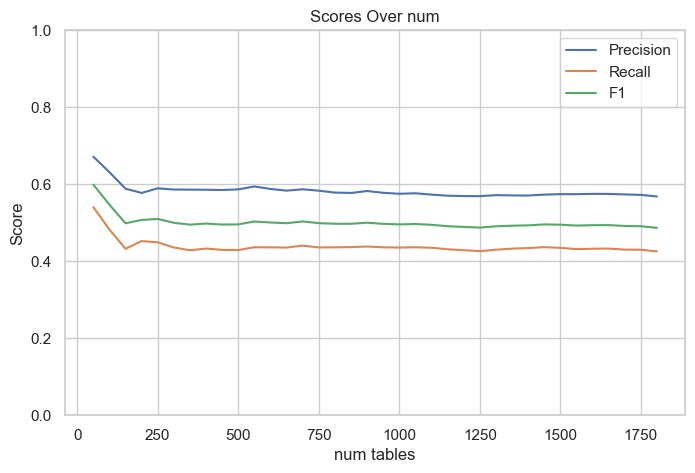

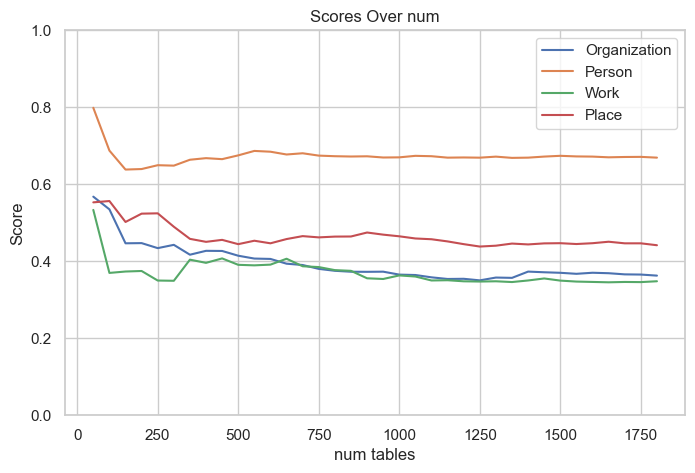

In [185]:
test = plot_results('gpt-35-turbo-instruct', '0', labels_dict)
test["f1"].mean()

In [181]:
def plot_barplot(model_name, shot):
    
    file_name = 'results_{}_{}'.format(model_name, shot)   
    data = pd.read_csv(os.path.join('../output/comma_deli', file_name+'.csv'))
    data = data.rename(columns=labels_dict)
    data.fillna(0, inplace=True)
    
    f1 = []
    classes = ['Activity', 'Organisation', 'ArchitecturalStructure','Event', 'Place', 'Person', 'Work']
    for class_name in classes:
        f1.append(data[class_name].mean())
        
    data_class = { 'Class':classes,'F1 Score':f1, 'reduced':True}
    df = pd.DataFrame(data_class)
    
    plt.figure(figsize=(10, 6))
    palette = 'Pastel1'
    for i, row in df.iterrows():    
        sns.barplot(x='Class', y='F1 Score', hue='Class', data=df, palette=palette)
    # Add labels and title
    sns.set(style="whitegrid")
    plt.xticks(rotation=15)
    plt.ylim(0, 0.9)
    plt.xlabel('Class')
    plt.ylabel('Mean F1 Score')
    #plt.title("{}".format(model_name.upper()))
    plt.title("GPT-3.5-turbo-instruct")
    
    #plt.show()
    save_filename = "class_{}_{}.png".format(model_name.upper(), shot)
    
    return df
    
    #plt.savefig(os.path.join("../output/plots", save_filename))

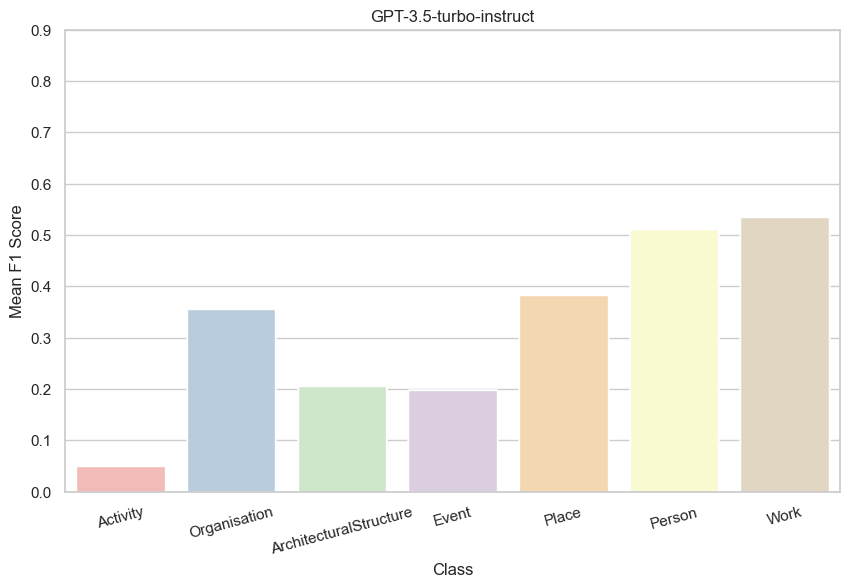

In [182]:
df_gpt_35_0 = plot_barplot("gpt-4",0)

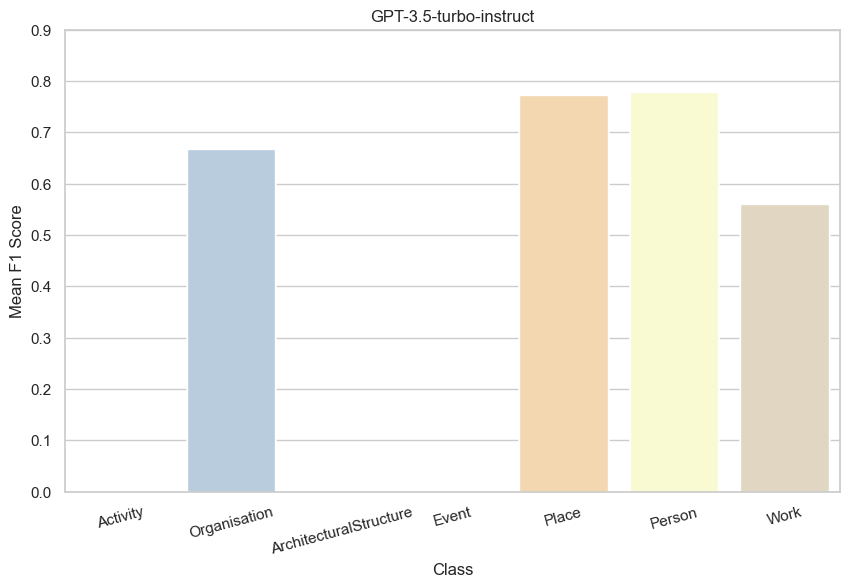

In [176]:
df_gpt_35_3_filtered = plot_barplot("gpt-35-turbo-16k",3)

In [177]:
gpt_inst = pd.concat([df_gpt_35_0,df_gpt_35_3_filtered])

In [ ]:

plt.figure(figsize=(9, 6))
palette = 'muted'

g = sns.catplot(
    data=gpt_inst, kind="bar",
    x='Class', y='F1 Score', hue='reduced',  palette=palette, alpha=.5, height=7.5, dodge=False
)
# Add labels and title
sns.set(style="whitegrid")
plt.xticks(rotation=15)
plt.ylim(0, 0.9)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Mean F1 Score', fontsize=16)
plt.title("GPT-3.5-turbo")

#plt.savefig(os.path.join("../output/plots", "GPT-35-turbo-instruct_both.png"), bbox_inches = "tight")

### LLama per class bar plot - results are taken from the Llama_model notebook

In [80]:
llama2_3shot_sim= {5: 0.41476424151909536, 1: 0.22614840989399287, 6: 0.3753812032159689, 7: 0.14384508990318118, 2: 0.3681090693538826, 3: 0.28609625668449196, 4: 0.3216374269005848}
llama2_0shot_sim= {6: 0.03505911129229515, 2: 0.014369106421194431, 3: 0.0036968576709796677, 7: 0.003273322422258592, 5: 0.0006795786612300373}

In [95]:
df0 = pd.DataFrame(list(labels_dict.items()), columns=['Label', 'Class'])
df0['F1 Score'] = df0['Label'].astype(int).map(llama2_0shot_sim)
df0['k-shot'] = 0

In [96]:
df3 = pd.DataFrame(list(labels_dict.items()), columns=['Label', 'Class'])
df3['F1 Score'] = df3['Label'].astype(int).map(llama2_3shot_sim)
df3['k-shot'] = 3

In [108]:
df = pd.concat([df0, df3])
df.fillna(0, inplace=True)

In [103]:
del df['Label']

In [109]:
df

,Label,Class,F1 Score,k-shot
0,1,Activity,0.000000,0
1,2,Organisation,0.014369,0
2,3,ArchitecturalStructure,0.003697,0
3,4,Event,0.000000,0
4,5,Place,0.000680,0
5,6,Person,0.035059,0
6,7,Work,0.003273,0
0,1,Activity,0.226148,3
1,2,Organisation,0.368109,3
2,3,ArchitecturalStructure,0.286096,3


<Figure size 900x600 with 0 Axes>

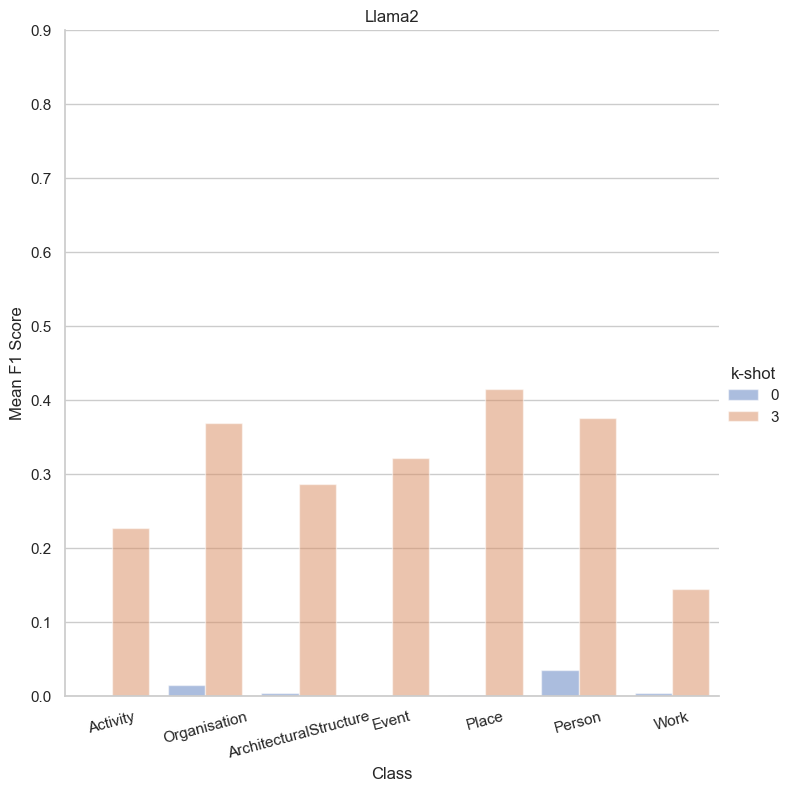

In [113]:
plt.figure(figsize=(9, 6))
palette = 'muted'

g = sns.catplot(
    data=df, kind="bar",
    x='Class', y='F1 Score', hue='k-shot',  palette=palette, alpha=.5, height=7.5, dodge=True
)
# Add labels and title
sns.set(style="whitegrid")
plt.xticks(rotation=15)
plt.ylim(0, 0.9)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title("Llama2")

plt.savefig(os.path.join("../output/plots", "Llama2_both.png"), bbox_inches = "tight")